# ViT

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import matplotlib.pyplot as plt
import logging 

logging.basicConfig(level=logging.DEBUG, filename='logs/vit_cifar10_fromscratch.log', filemode='w', format='%(message)s')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# Split the training set into training and validation sets
# trainset, valset = train_test_split(trainset, test_size=0.1, random_state=42)
train_indices, val_indices = torch.utils.data.random_split(list(range(len(trainset))), [45000, 5000])

# Create the train and validation datasets
valset = torch.utils.data.Subset(trainset, val_indices)
trainset = torch.utils.data.Subset(trainset, train_indices)

# Print the sizes of the new datasets
print("Training set size:", len(trainset))
print("Validation set size:", len(valset))

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=128, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=8, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
from vit_pytorch import ViT

net = ViT(
    image_size = 32,
    patch_size = 8,
    num_classes = 10,
    dim = 512,
    depth = 8,
    heads = 8,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1
)
# count number of elements in the model
pytorch_total_params = sum(p.numel() for p in net.parameters())
print(pytorch_total_params)

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)




==> Preparing data..
Files already downloaded and verified
Training set size: 45000
Validation set size: 5000
Files already downloaded and verified
==> Building model..
12727178


In [2]:
# Training
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Instead of use progress bar, print it directly
        if batch_idx % 10 == 0:
            logging.debug(f'Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total})')
        train_losses.append(train_loss/(batch_idx+1))
        train_accuracies.append(100.*correct/total)

        
def test(epoch):
    global best_acc
    net.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:
                logging.debug(f'>>> Validation Loss: {valid_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total})')
        # Append average loss and accuracy
        test_losses.append(valid_loss/(batch_idx+1))
        test_accuracies.append(100.*correct/total)
            
            
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/vit_cifar10.pth')
        best_acc = acc


def print_curves(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = len(test_losses)
    total_train_points = len(train_losses)
    epoch_indices = np.linspace(0, total_train_points - 1, epochs, dtype=int)

    # Downsampling training losses to match the number of epochs
    # We select points from train_losses at positions matching to test_losses
    train_losses_sampled = [train_losses[i] for i in epoch_indices]

    # Plotting both sets of losses
    plt.figure(figsize=(30, 5))
    plt.plot(train_losses_sampled, label='Train Loss (Sampled)')
    plt.plot(test_losses, label='Validation Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss per Epoch')
    plt.xticks(range(epochs), labels=[f'{i+1}' for i in range(epochs)])  # Set x-ticks to epoch numbers
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the accuracies curves
    epochs = len(test_accuracies)
    total_train_points = len(train_accuracies)
    epoch_indices = np.linspace(0, total_train_points - 1, epochs, dtype=int)
    # print(epoch_indices)
    train_accuracies_sampled = [train_accuracies[i] for i in epoch_indices]
    plt.figure(figsize=(30, 5))
    plt.plot(train_accuracies_sampled, label='Train Accuracy')
    plt.plot(test_accuracies, label='Validation Accuracy', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy per Epoch')
    plt.xticks(range(epochs), labels=[f'{i+1}' for i in range(epochs)])  # Set x-ticks to epoch numbers
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
for epoch in range(start_epoch, start_epoch+50):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
Saving..

Epoch: 1
Saving..

Epoch: 2
Saving..

Epoch: 3
Saving..

Epoch: 4
Saving..

Epoch: 5
Saving..

Epoch: 6
Saving..

Epoch: 7
Saving..

Epoch: 8

Epoch: 9

Epoch: 10

Epoch: 11
Saving..

Epoch: 12
Saving..

Epoch: 13

Epoch: 14
Saving..

Epoch: 15
Saving..

Epoch: 16
Saving..

Epoch: 17

Epoch: 18

Epoch: 19
Saving..

Epoch: 20

Epoch: 21

Epoch: 22

Epoch: 23

Epoch: 24

Epoch: 25

Epoch: 26
Saving..

Epoch: 27

Epoch: 28

Epoch: 29

Epoch: 30

Epoch: 31
Saving..

Epoch: 32

Epoch: 33

Epoch: 34

Epoch: 35
Saving..

Epoch: 36
Saving..

Epoch: 37

Epoch: 38

Epoch: 39
Saving..

Epoch: 40
Saving..

Epoch: 41

Epoch: 42

Epoch: 43

Epoch: 44

Epoch: 45

Epoch: 46

Epoch: 47

Epoch: 48

Epoch: 49


In [4]:
correct = 0
total = 0

# Set the model to evaluation mode
net.eval()

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Count the number of correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate test set accuracy
accuracy = 100 * correct / total

print('Test Set Accuracy: {:.2f}%'.format(accuracy))


Test Set Accuracy: 62.42%


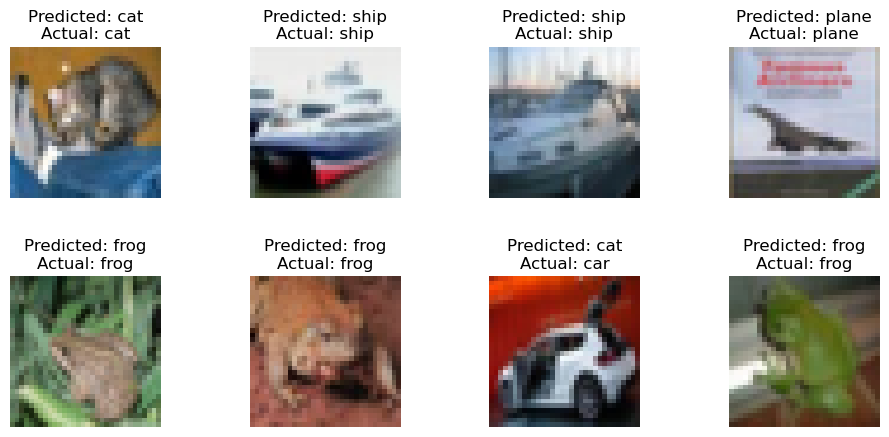

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
net.eval()

# Iterate over the testloader
for i, (images, labels) in enumerate(testloader):
    # if i == 0:
    #     continue
    # Move images and labels to the device
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    
    # Convert tensors to numpy arrays
    images = images.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    # print(images.shape)
    # print(labels.shape)
    # print(predicted.shape)
    
    # Visualize the images and classification results
    fig, axes = plt.subplots(2, len(images)//2, figsize=(10, 5))
    fig.tight_layout(pad=3.0)

    for i, ax in enumerate(axes.flat):
        # Convert the image from tensor to numpy array
        image = np.transpose(images[i], (1, 2, 0))
        
        # Denormalize the image
        image = image * np.array([0.2023, 0.1994, 0.201]) + np.array([0.4914, 0.4822, 0.4465])
        
        # Clip the pixel values to [0, 1]
        image = np.clip(image, 0, 1)
        
        # Plot the image and set the title
        ax.imshow(image)
        ax.set_title(f"Predicted: {classes[predicted[i]]}\nActual: {classes[labels[i]]}")
        
        # Remove the axis ticks
        ax.axis('off')
    
    # Show the plot
    plt.show()
    break



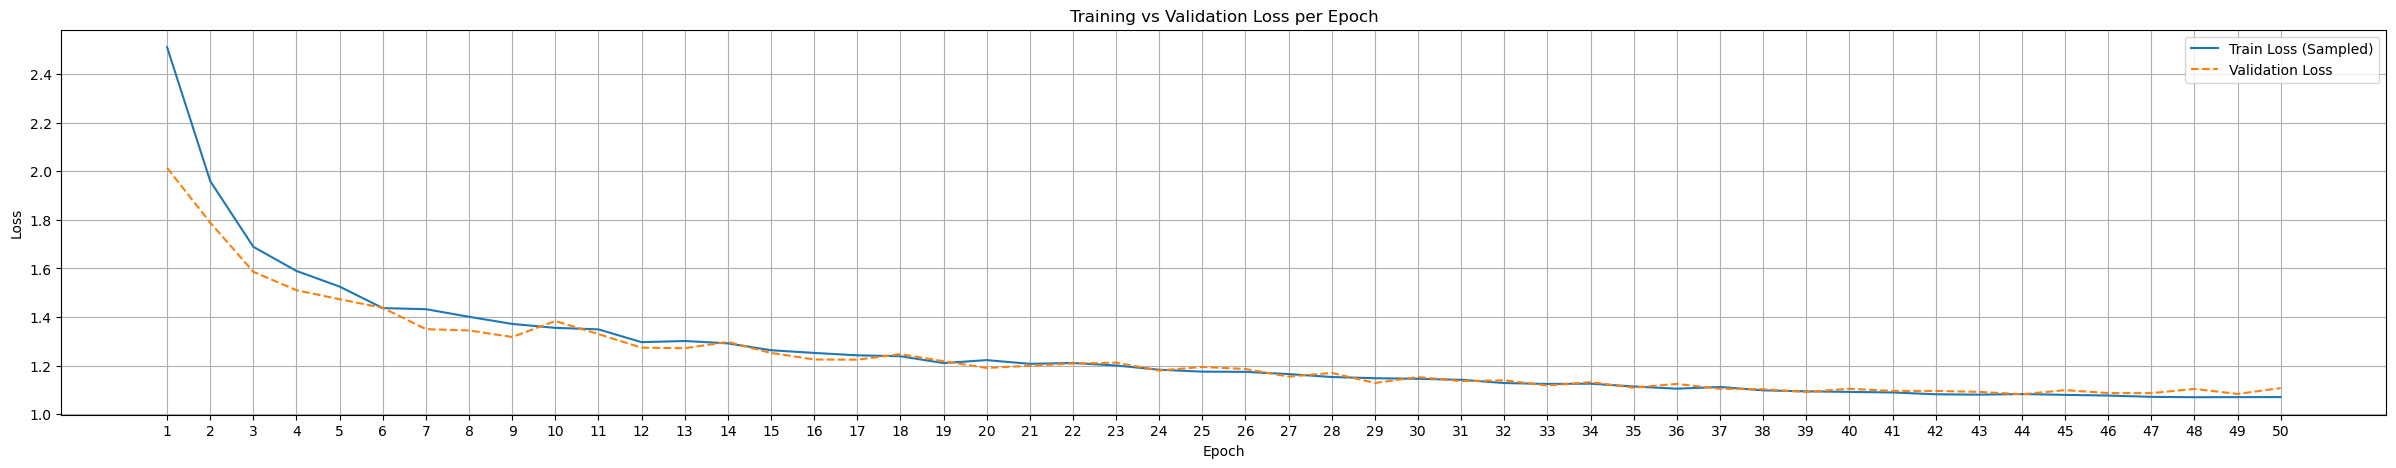

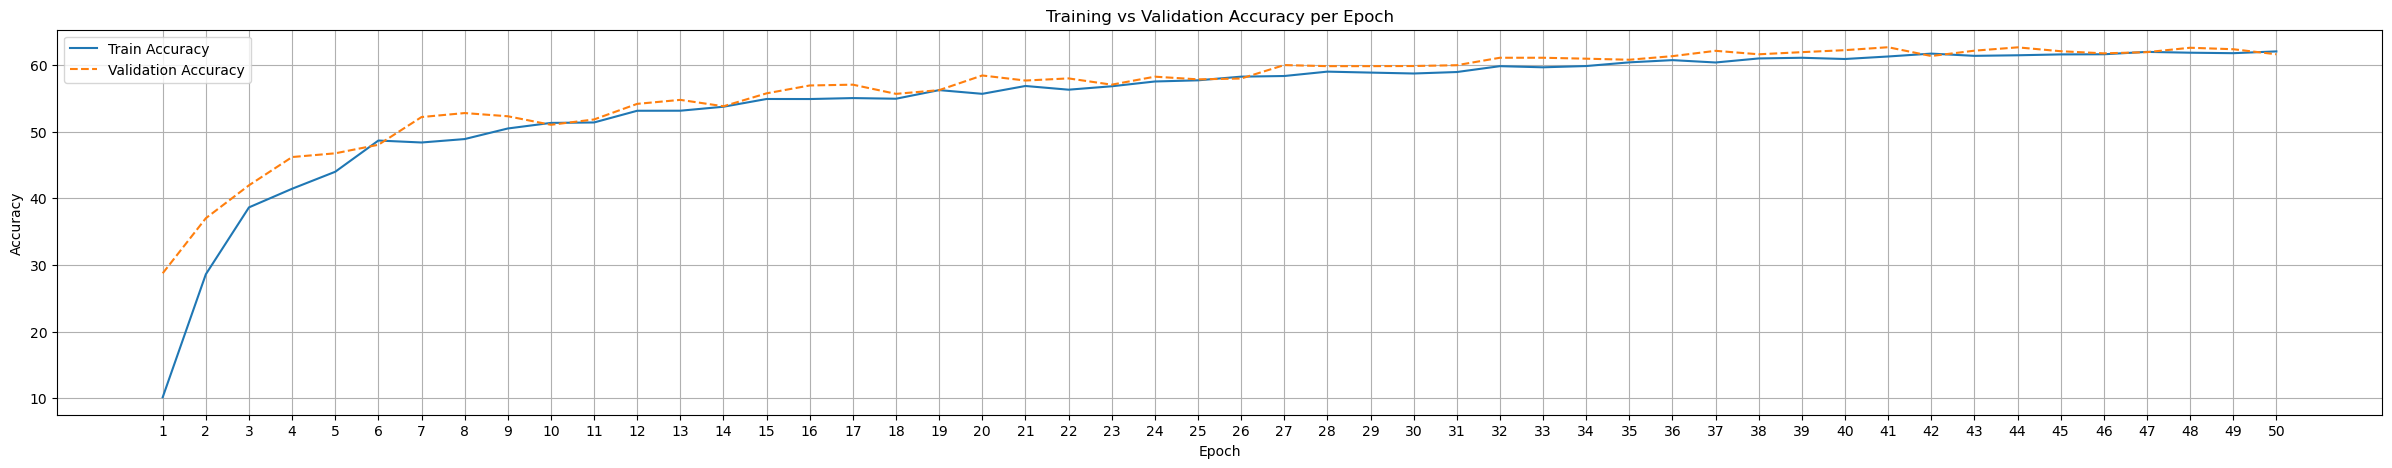

None


In [6]:
print(print_curves(train_losses, test_losses, train_accuracies, test_accuracies))